In [1]:
import xarray as xr
import numpy as np
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
yellow = HTI_forecasted_count.isel(time=0)*0        ; treshold_yellow = 0.73
brown  = HTI_forecasted_count.isel(time=0)*0        ; treshold_brown  = 0.90
red    = HTI_forecasted_count.isel(time=0)*0        ; treshold_red    = 0.99
temp = []
k = 0
print(len(os.listdir("source_disk/MEPS/HTI_forecast/")))
for file in sorted(os.listdir("source_disk/MEPS/HTI_forecast/")):
    if file.endswith(".nc"):
        k +=1
        HTI_forecasted_count = xr.open_dataset("source_disk/MEPS/HTI_forecast/"+file)["helicopter_triggered_index"]
        try:
            yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
            brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
            red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
        except xr.MergeError:
            temp.append([yellow,brown,red])
            yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
            brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
            red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
    if k%250 == 0:
        print(k)

yellow = temp[0][0].reset_coords("time",drop=1) + yellow.sel(x=temp[0][0].x,method="nearest").values
brown  = temp[0][1].reset_coords("time",drop=1) + brown.sel(x=temp[0][1].x,method="nearest").values
red    = temp[0][2].reset_coords("time",drop=1) + red.sel(x=temp[0][2].x,method="nearest").values
for elem in temp[1:]:
    yellow += elem[0].reset_coords("time",drop=1) + yellow.sel(x=temp[0][0].x,method="nearest").values
    brown  += elem[1].reset_coords("time",drop=1) + brown.sel(x=temp[0][1].x,method="nearest").values
    red    += elem[2].reset_coords("time",drop=1) + red.sel(x=temp[0][2].x,method="nearest").values

4496
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250


In [4]:
k

4495

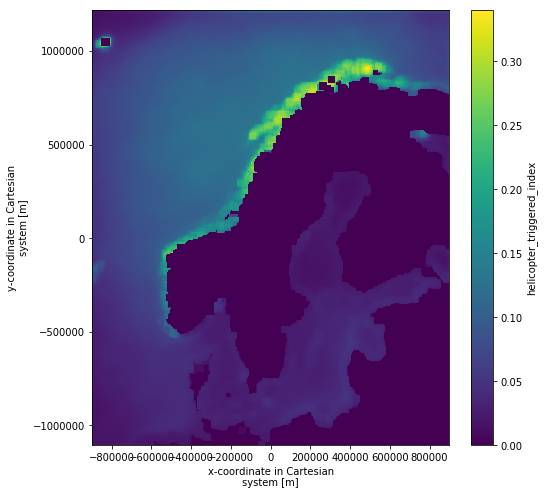

In [5]:
plt.figure(figsize=(8,8))
(yellow/(k*20)).plot()

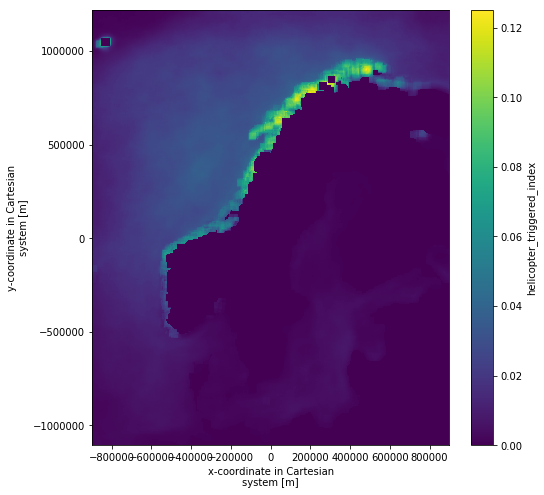

In [6]:
plt.figure(figsize=(8,8))

(brown/(k*20)).plot()

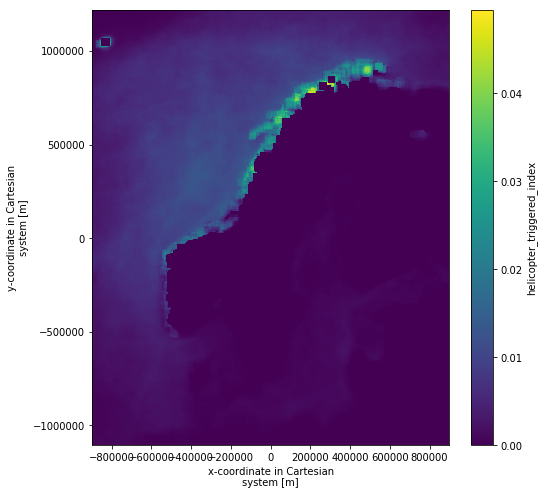

In [7]:
plt.figure(figsize=(8,8))

(red/(k*20)).plot()

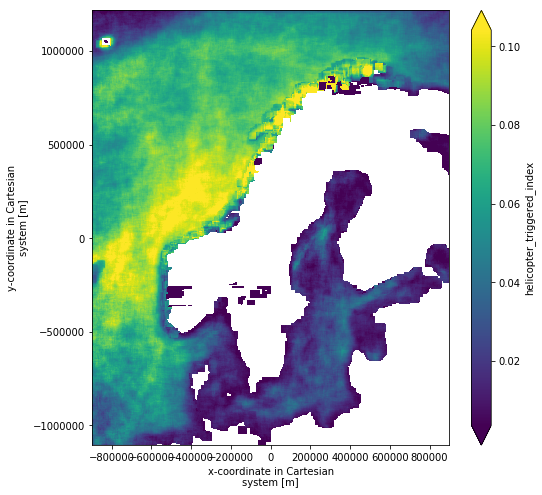

In [8]:
plt.figure(figsize=(8,8))

(red/yellow).plot(robust=1)

In [17]:
ds = xr.merge([yellow.rename("yellow"),brown.rename("brown"),red.rename("red")])/(k*20)

In [19]:
ds.to_netcdf("source_disk/results/HTI_climatology_MEPS")